In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from matplotlib.colors import ListedColormap

In [2]:
# loading the output

data0 = pd.read_csv('./out/out0.csv') #Z0.02
data1= pd.read_csv('./out/out1.csv') #Z0.00014

In [4]:
# adding to the dataframes a column: mass ratio = mass_BH / mass_WR
df0 = data0.copy()
mask = ~(df0['PhaseBSE_0']==14.0)
df0.loc[mask, ['Mass_0', 'Mass_1']] = (df0.loc[mask, ['Mass_1', 'Mass_0']].values) 
df0 = df0.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df0 = df0.rename(columns={"Mass_0_initial": "Mass_BH_in", "Mass_1_initial": "Mass_WR_in"})
df0 = df0.rename(columns={"a": "Semimajor_in", "e": "Eccentricity_in"})
df0['Mass_ratio'] = df0['Mass_BH'] / df0['Mass_WR']

df1 = data1.copy()
mask = ~(df1['PhaseBSE_0']==14.0)
df1.loc[mask, ['Mass_0', 'Mass_1']] = (df1.loc[mask, ['Mass_1', 'Mass_0']].values)
df1 = df1.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df1 = df1.rename(columns={"Mass_0_initial": "Mass_BH_in", "Mass_1_initial": "Mass_WR_in"})
df1 = df1.rename(columns={"a": "Semimajor_in", "e": "Eccentricity_in"})
df1['Mass_ratio'] = df1['Mass_BH'] / df1['Mass_WR']

------------------

First, we examine the correlations between the features. To improve our feature selection, we add a random feature and exclude those whose importance is smaller than that of the random feature.

In [18]:
rand_0=pd.DataFrame({'rand_0': np.random.rand(len(df0))})
rand_1=pd.DataFrame({'rand_1': np.random.rand(len(df1))})

<span style="color:red">Non si visualizzano tutti i parametri qui sotto:</span>

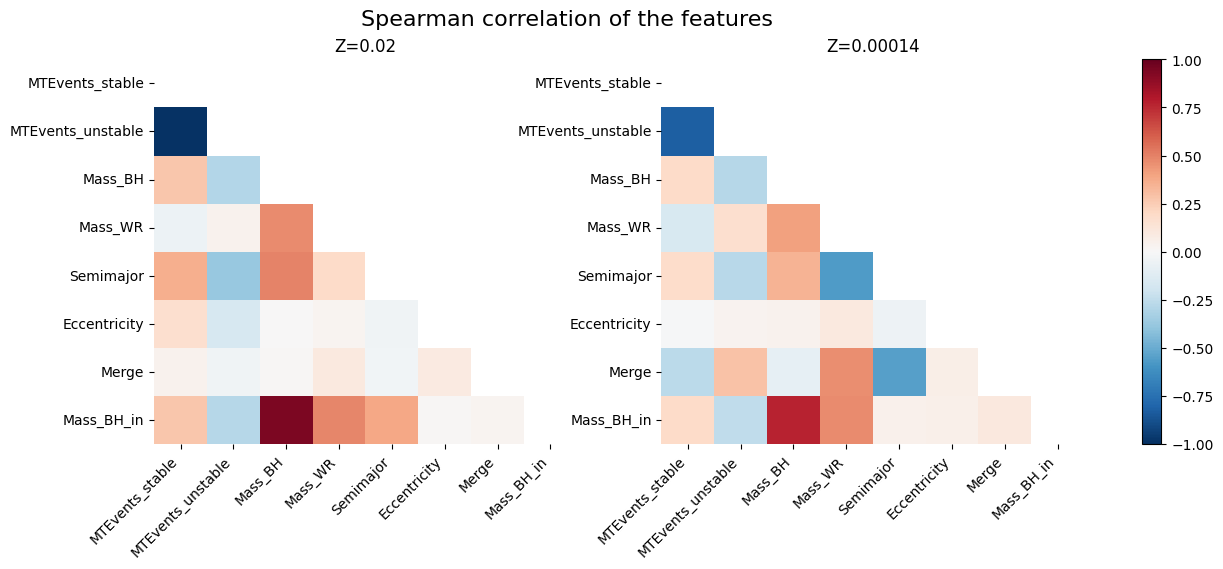

In [19]:
# spearman correlation

fig,axs=plt.subplots(1,2,figsize=(15,5))
corr_matrix_0 = df0.iloc[:,[1,2,4,5,6,7,8,9]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_0, dtype=bool))
sns.heatmap(corr_matrix_0, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[0],vmin=-1, vmax=1,cbar=False)
axs[0].set_title('Z=0.02')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

corr_matrix_1 = df1.iloc[:,[1,2,4,5,6,7,8,9]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_1, dtype=bool))
sns.heatmap(corr_matrix_1, mask=mask, cmap='RdBu_r', linecolor='w',ax=axs[1],vmin=-1, vmax=1,cbar=False)
axs[1].set_title('Z=0.00014')
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
fig.colorbar(axs[0].collections[0], ax=axs)
fig.suptitle('Spearman correlation of the features',ha='center',fontsize=16,x=0.4)
plt.show()

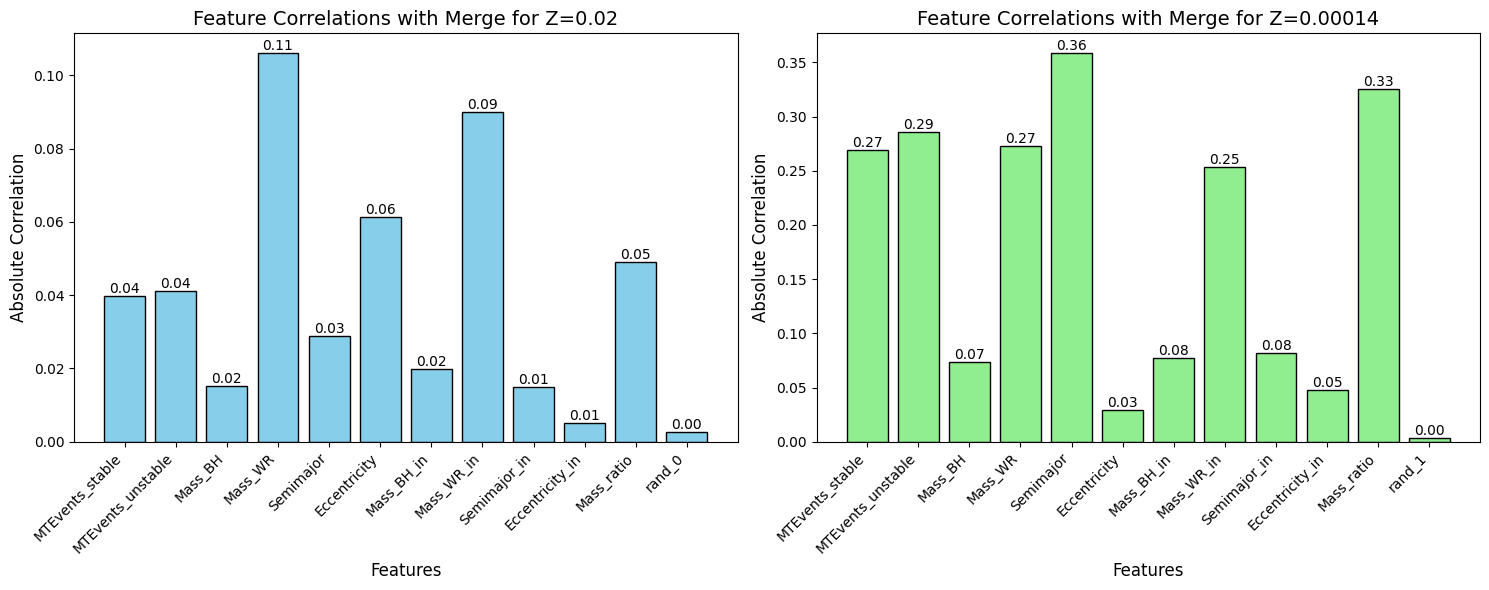

In [20]:
# absolute correlation

col0 = df0.drop(columns=["Merge",'ID','PhaseBSE_0'])
columns0 = pd.concat([col0, rand_0], axis=1)
correlation_dict0 = {}
for column in columns0:
    correlation = columns0[column].corr(df0['Merge'])
    correlation_dict0[column] = correlation
correlation_df0=pd.DataFrame(correlation_dict0,index=['Correlation']).T

col1 = df1.drop(columns=["Merge",'ID', 'PhaseBSE_0'])
columns1 = pd.concat([col1, rand_1], axis=1)
correlation_dict1 = {}
for column in columns1:
    correlation = columns1[column].corr(df1['Merge'])
    correlation_dict1[column] = correlation
correlation_df1=pd.DataFrame(correlation_dict1,index=['Correlation']).T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for the first bar chart
bars0 = axes[0].bar(x=range(len(abs(correlation_df0))), height=abs(correlation_df0['Correlation']), color='skyblue', edgecolor='black')
axes[0].set_xlabel('Features', fontsize=12)
axes[0].set_ylabel('Absolute Correlation', fontsize=12)
axes[0].set_title('Feature Correlations with Merge for Z=0.02', fontsize=14)
axes[0].set_xticks(range(len(abs(correlation_df0))))
axes[0].set_xticklabels(abs(correlation_df0).index, rotation=45, ha='right')

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Plot for the second bar chart
bars1 = axes[1].bar(x=range(len(abs(correlation_df1))), height=abs(correlation_df1['Correlation']), color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Features', fontsize=12)
axes[1].set_ylabel('Absolute Correlation', fontsize=12)
axes[1].set_title('Feature Correlations with Merge for Z=0.00014', fontsize=14)
axes[1].set_xticks(range(len(abs(correlation_df1))))
axes[1].set_xticklabels(abs(correlation_df1).index, rotation=45, ha='right')

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

-------------------------
## Intermediate conditions 

We now implement a Random Forest algorithm to predict whether a system merges via emission of GW or not.

We start by shuffling and splitting the dataset in test and train set:

In [12]:
def splitting_data(df, features, ratio=0.8):

    df = df.sample(frac=1)
    x = df[features].copy()
    
    #### setting Semimajor in log scale + normalizing 
    
    if 'Semimajor' in features:
        x['Semimajor'] = np.log10(x['Semimajor'])
    elif 'Semimajor_in' in features:
            x['Semimajor_in'] = np.log10(x['Semimajor_in'])

    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    
    x = pd.DataFrame(x, columns=features)
    y = df.Merge

    N= x.shape[0]
    N_train = int(ratio * N)
    
    x_train = x.iloc[:N_train].reset_index(drop=True)
    y_train = y.iloc[:N_train].reset_index(drop=True)
    x_test = x.iloc[N_train:].reset_index(drop=True)
    y_test = y.iloc[N_train:].reset_index(drop=True)
    
    return(x_train, y_train, x_test, y_test)

In [12]:
features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test = splitting_data(df0, features)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test = splitting_data(df1, features)

In [11]:
print(f'Z=0.02: fraction of merging BBH is {df0[df0.Merge==1].count().iloc[0]} / {df0.size} = {df0[df0.Merge==1].count().iloc[0]/df0.size}')
print(f'Z=0.00014: fraction of merging BBH is {df1[df1.Merge==1].count().iloc[0]} / {df1.size} ={df1[df1.Merge==1].count().iloc[0]/df1.size}')

Z=0.02: fraction of merging BBH is 196 / 315950 = 0.0006203513214116157
Z=0.00014: fraction of merging BBH is 19328 / 1078250 =0.01792534198933457


We can clearly observe that the dataset at higher metallicity is quite imbalanced, showing fewer merging systems compared to non-merging ones. To address this issue, we will employ two different techniques:

1) Setting an higher weight for class 1 (merging systems) and randomly removing samples from class 0 (non-merging systems):

In [7]:
def grid_search(param_grid, x_train, y_train, class_weight={0:1, 1:1}):
    RF = RandomForestClassifier(criterion='gini', class_weight=class_weight) 
    search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    results = search.fit(x_train, y_train)
    df_results = pd.DataFrame(results.cv_results_)
    df_results['mean_fit_time'] = results.cv_results_['mean_fit_time']
    df_results = df_results[['rank_test_score','mean_fit_time','std_fit_time','params',
                            'mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False)
    best_params = df_results['params'][0]
    return(df_results, best_params)


In [13]:
##################################### manually setting class weight and sampling strategy

rus = RandomUnderSampler(sampling_strategy=0.015)
x0_train, y0_train = rus.fit_resample(x0_train, y0_train)

param_grid0 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}
df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train, class_weight=class_weight)

best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1, class_weight=class_weight)
best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

print("Best Parameters:", best_params0)
print("Metallicity 0.02: Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.02: Errors=14.15%, Accuracy=0.859


In [8]:
############# same thing as above but without resampling 

param_grid1 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train)

best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1)
fit1 = best_RF1.fit(x1_train,y1_train)

print("Best Parameters:", best_params1)
print("Metallicity 0.00014: Errors={:.2f}%, Accuracy ={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.00014: Errors=6.39%, Accuracy =0.936


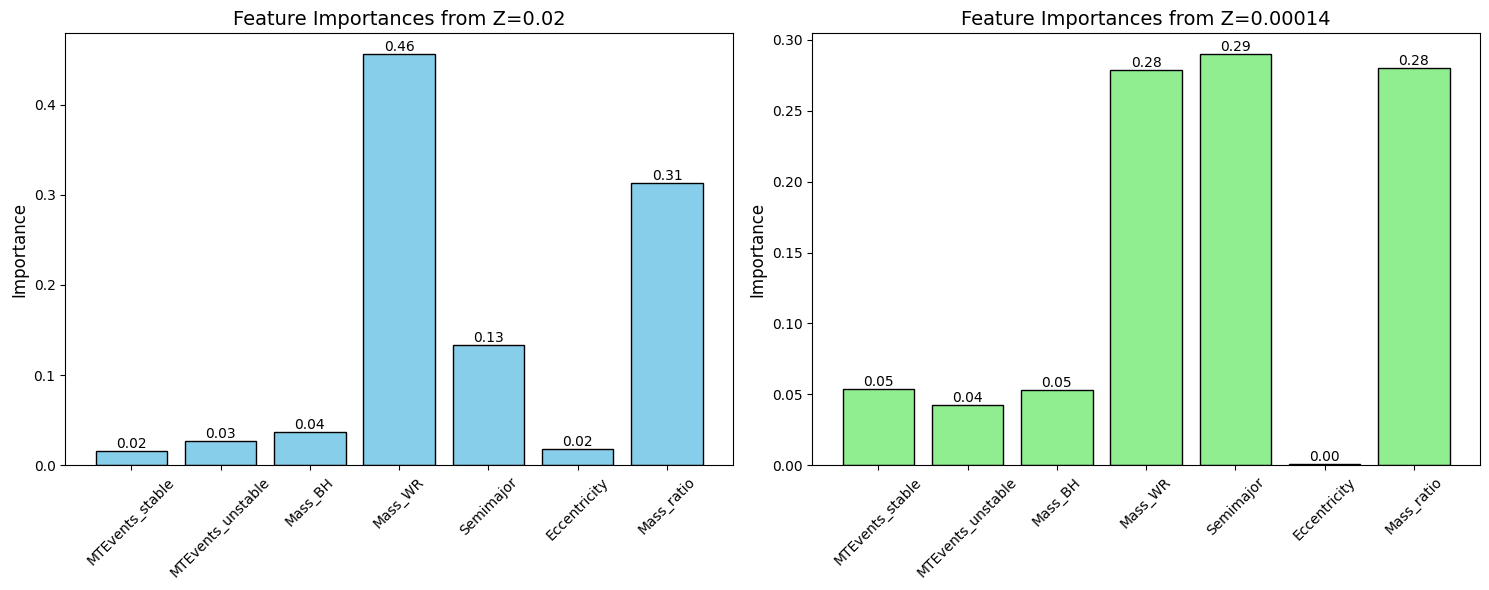

In [17]:
# Random Forest features importance 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  

bars0 = axes[0].bar(features, best_RF0.feature_importances_, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Feature Importances from Z=0.02', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)


bars1 = axes[1].bar(features, best_RF1.feature_importances_, color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Feature Importances from Z=0.00014', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  
plt.show()

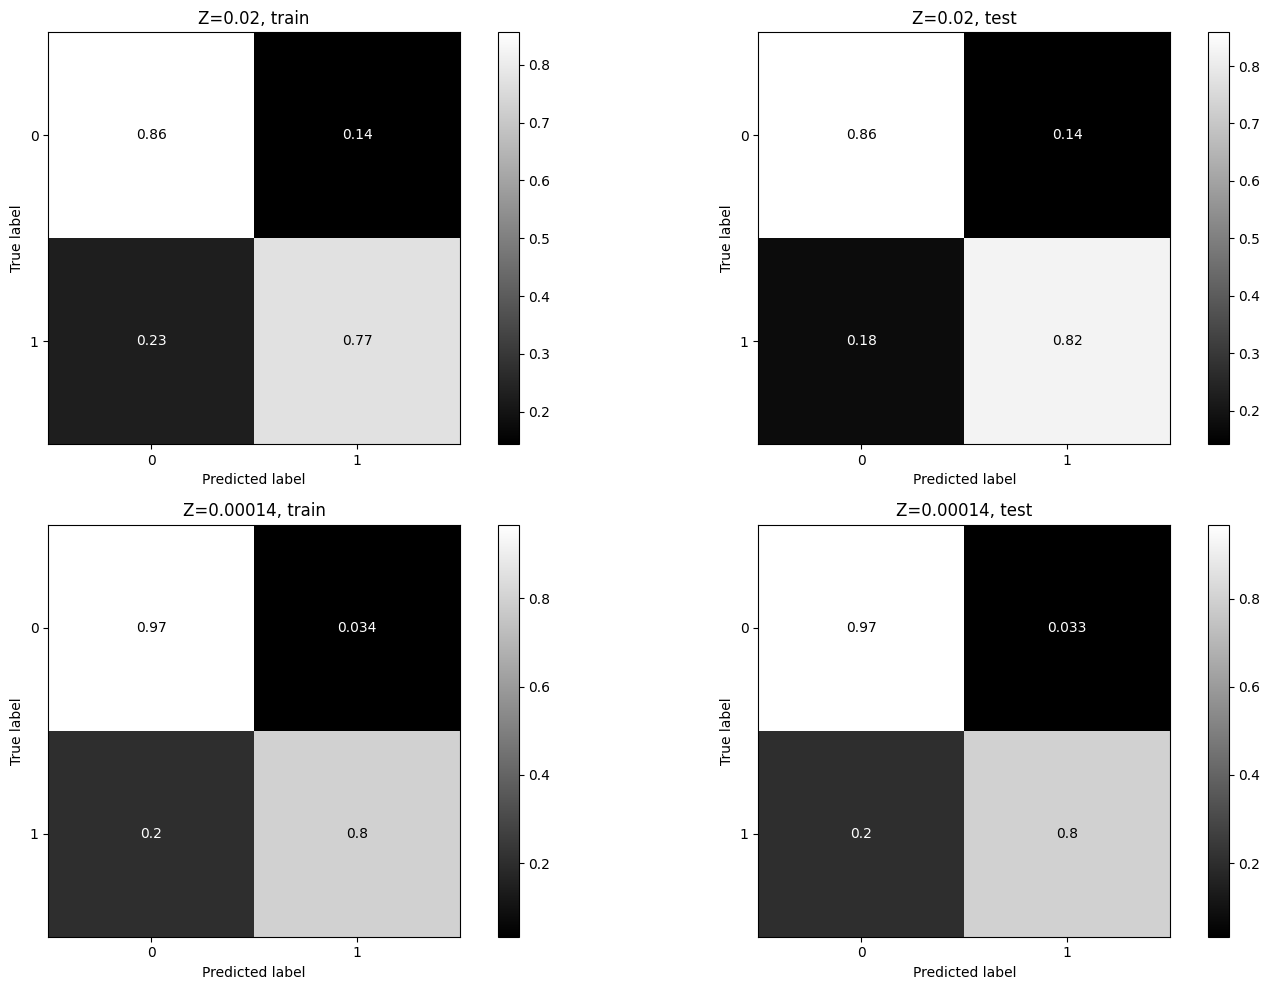

In [18]:
# confusion matrices

cm_0_train=confusion_matrix(y0_train,pred0_train,normalize='true')
cm_0_test=confusion_matrix(y0_test,pred0_test,normalize='true')
cm_1_train=confusion_matrix(y1_train,best_RF1.predict(x1_train),normalize='true')
cm_1_test=confusion_matrix(y1_test,best_RF1.predict(x1_test),normalize='true')

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='grey')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='grey')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='grey')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='grey')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()

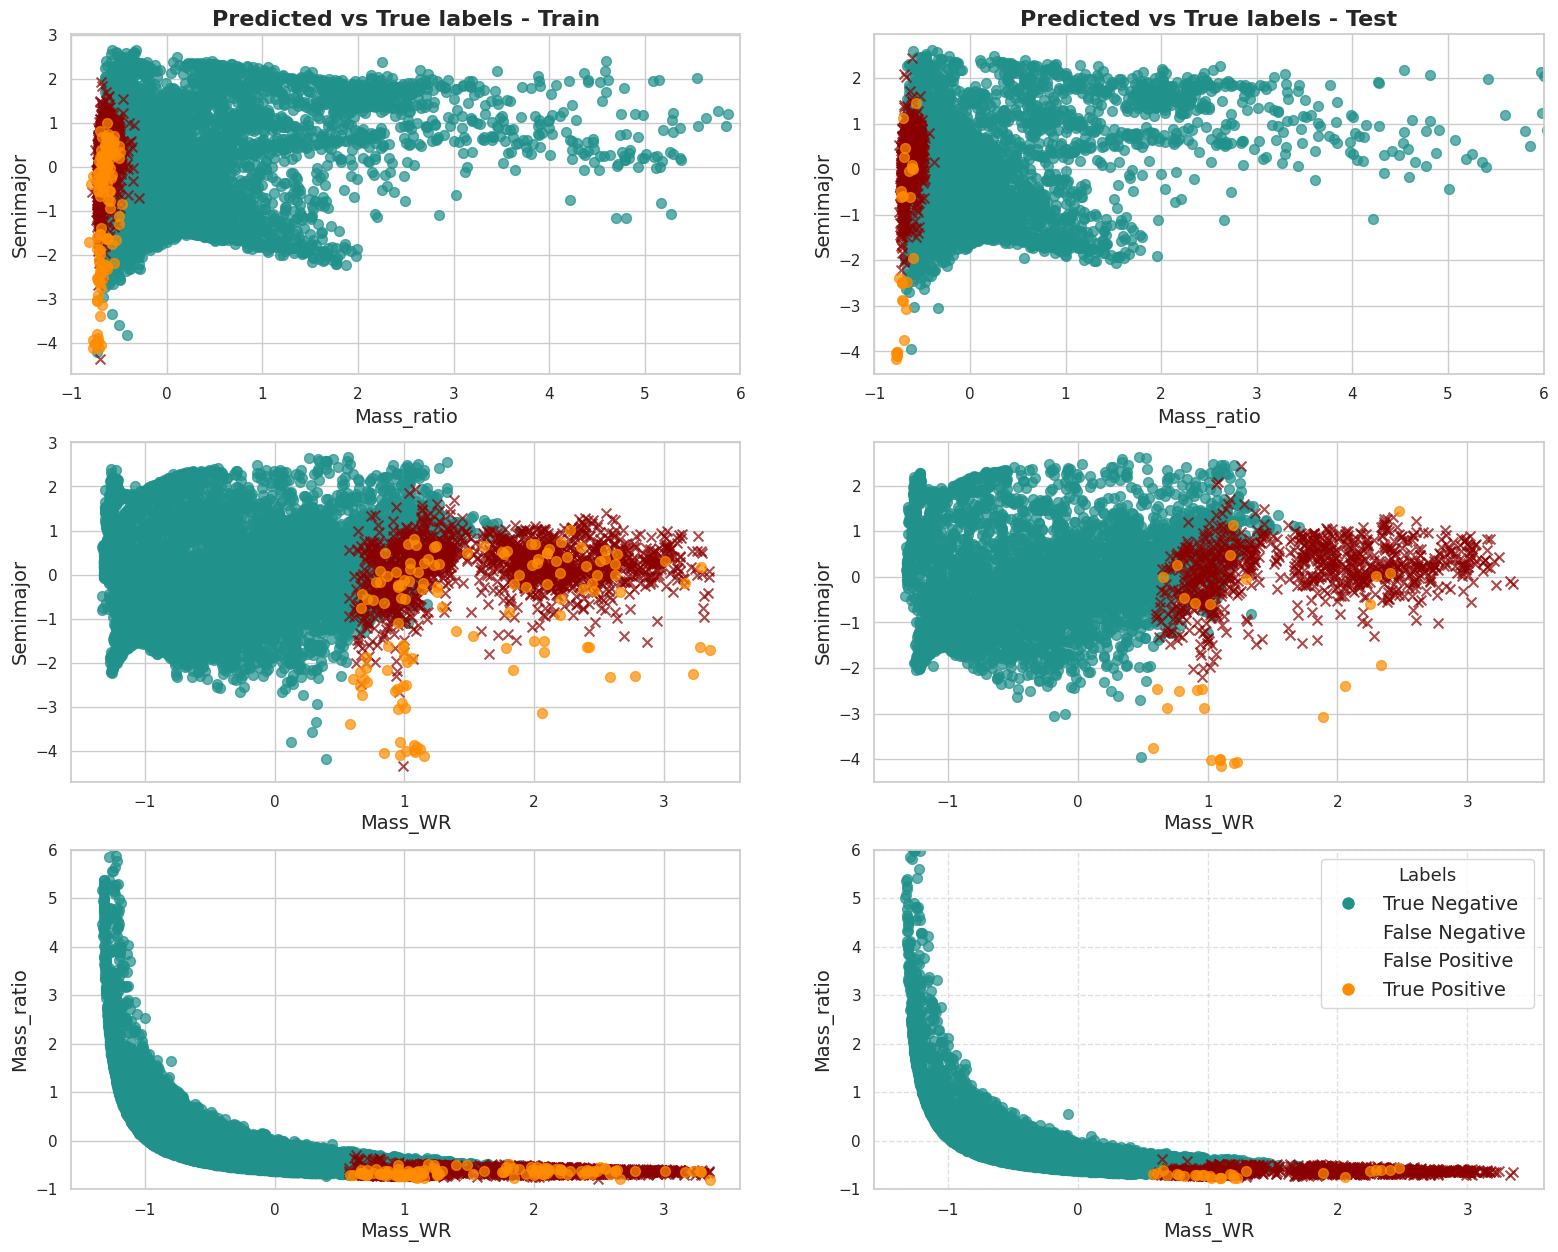

In [19]:
cmap = ListedColormap(['#21918C', 'darkred', 'darkred', 'darkorange'])
labels = ['True Negative', 'False Negative', 'False Positive', 'True Positive']
markers = {0: 'o', 1: 'x', 2: 'x', 3: 'o'}

sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(19, 15)) 

pair_test = np.column_stack((y0_test, pred0_test))
label_test = pair_test[:, 0] + 2*pair_test[:, 1]

pair_train = np.column_stack((y0_train, pred0_train)) 
label_train = pair_train[:, 0] + 2*pair_train[:, 1]


def plot_scatter(ax, x, y, labels, markers, cmap):
    for label, marker in markers.items():
        indices = (labels == label)
        ax.scatter(x[indices], y[indices], s=50, c=[cmap(label)], marker=marker, alpha=0.7)


plot_scatter(axes[0, 0], x0_train['Mass_ratio'], x0_train['Semimajor'], label_train, markers, cmap)
axes[0, 0].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 0].set_ylabel('Semimajor', fontsize=14)
axes[0, 0].set_title('Predicted vs True labels - Train', fontsize=16, fontweight='bold')
axes[0, 0].set_xlim(-1, 6)

plot_scatter(axes[1, 0], x0_train['Mass_WR'], x0_train['Semimajor'], label_train, markers, cmap)
axes[1, 0].set_xlabel('Mass_WR', fontsize=14)
axes[1, 0].set_ylabel('Semimajor', fontsize=14)

plot_scatter(axes[2, 0], x0_train['Mass_WR'], x0_train['Mass_ratio'], label_train, markers, cmap)
axes[2, 0].set_xlabel('Mass_WR', fontsize=14)
axes[2, 0].set_ylabel('Mass_ratio', fontsize=14)
axes[2, 0].set_ylim(-1, 6)

plot_scatter(axes[0, 1], x0_test['Mass_ratio'], x0_test['Semimajor'], label_test, markers, cmap)
axes[0, 1].set_xlabel('Mass_ratio', fontsize=14)
axes[0, 1].set_ylabel('Semimajor', fontsize=14)
axes[0, 1].set_title('Predicted vs True labels - Test', fontsize=16, fontweight='bold')
axes[0, 1].set_xlim(-1, 6)

plot_scatter(axes[1, 1], x0_test['Mass_WR'], x0_test['Semimajor'], label_test, markers, cmap)
axes[1, 1].set_xlabel('Mass_WR', fontsize=14)
axes[1, 1].set_ylabel('Semimajor', fontsize=14)

plot_scatter(axes[2, 1], x0_test['Mass_WR'], x0_test['Mass_ratio'], label_test, markers, cmap)
axes[2, 1].set_xlabel('Mass_WR', fontsize=14)
axes[2, 1].set_ylabel('Mass_ratio', fontsize=14)
axes[2, 1].set_ylim(-1, 6)

plt.grid(True, linestyle='--', alpha=0.6)

handles = [plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor=cmap(i/3), markersize=10) for i, marker in markers.items()]
plt.legend(handles, labels, loc='upper right', fontsize=14, title='Labels', title_fontsize='13')

plt.show()


<span style="color:red">Sistemare legenda sopra</span>

2) Using SMOTE to generate more samples of class 1 for Z=0.02 dataset for the training set:

In [20]:
features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test = splitting_data(df0, features)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test = splitting_data(df1, features)

In [23]:
# we specified the ratio: class 1 samples / class 0 samples = 0.55

smote = SMOTE(sampling_strategy=0.55)
x0_train, y0_train = smote.fit_resample(x0_train, y0_train)

df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train)
best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1)
fit0 = best_RF0.fit(x0_train, y0_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


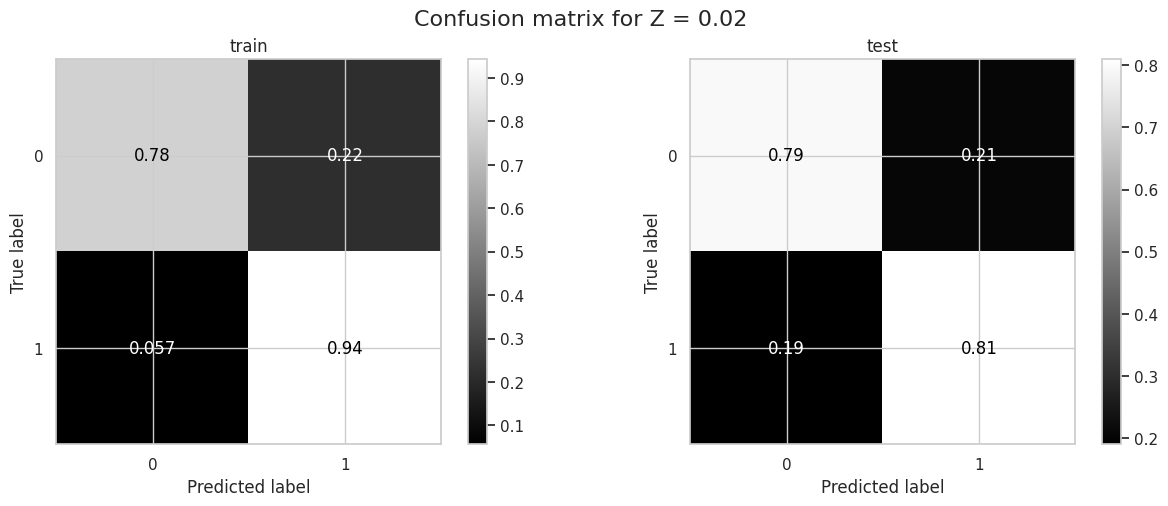

In [24]:
confusion_matrix_0train=confusion_matrix(y0_train,best_RF0.predict(x0_train),normalize='true')
confusion_matrix_0test=confusion_matrix(y0_test,best_RF0.predict(x0_test),normalize='true')

fig,ax=plt.subplots(1,2, figsize=(15,5))

ConfusionMatrixDisplay(confusion_matrix_0train).plot(ax=ax[0], cmap='grey')
ConfusionMatrixDisplay(confusion_matrix_0test).plot(ax=ax[1], cmap='grey')
fig.suptitle('Confusion matrix for Z = 0.02',ha='center',fontsize=16)
ax[0].set_title('train')
ax[1].set_title('test')

plt.show()

<span style="color:red">Conclusioni</span>

-------------------

## Initial conditions 

We repeat the same procedure, this time selecting only the initial conditions as features, to evaluate whether these alone can determine if a system merges via the emission of gravitational waves.  

<span style="color:red">Cambiare parametri Random Forest, forse bisogna fare resampling anche di df1 perchà performa male.</span>

In [29]:
features_in = ['Mass_BH_in', 'Mass_WR_in', 'Semimajor_in', 'Eccentricity_in']

# metallicity Z = 0.02
x0_train, y0_train, x0_test, y0_test = splitting_data(df0, features_in)

# metallicity Z = 0.00014
x1_train, y1_train, x1_test, y1_test = splitting_data(df1, features_in)

In [22]:
##################################### manually setting class weight and sampling strategy

rus = RandomUnderSampler(sampling_strategy=0.02)
x0_train, y0_train = rus.fit_resample(x0_train, y0_train)

param_grid0 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:30}
df0_results, best_params0 = grid_search(param_grid0, x0_train, y0_train, class_weight=class_weight)

best_RF0 = RandomForestClassifier(**best_params0, criterion='gini', n_jobs=-1, class_weight=class_weight)
best_RF0.fit(x0_train, y0_train)

pred0_test = best_RF0.predict(x0_test)
pred0_train = best_RF0.predict(x0_train)

print("Best Parameters:", best_params0)
print("Metallicity 0.02: Errors={:.2f}%, Accuracy={:.3f}".format(100*(1-best_RF0.score(x0_test, y0_test)), best_RF0.score(x0_test, y0_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.02: Errors=21.35%, Accuracy=0.787


In [33]:
############# same thing as above but without resampling 

param_grid1 = {'n_estimators': [30, 60, 80, 100], 'max_depth': [3, 5, 7]}
class_weight = {0:1, 1:50}

df1_results, best_params1 = grid_search(param_grid1, x1_train, y1_train, class_weight=class_weight)

best_RF1 = RandomForestClassifier(**best_params1, criterion='gini', n_jobs=-1)
fit1 = best_RF1.fit(x1_train,y1_train)

print("Best Parameters:", best_params1)
print("Metallicity 0.00014: Errors={:.2f}%, Accuracy ={:.3f}".format(100*(1-best_RF1.score(x1_test, y1_test)), best_RF1.score(x1_test, y1_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 30}
Metallicity 0.00014: Errors=12.27%, Accuracy =0.877


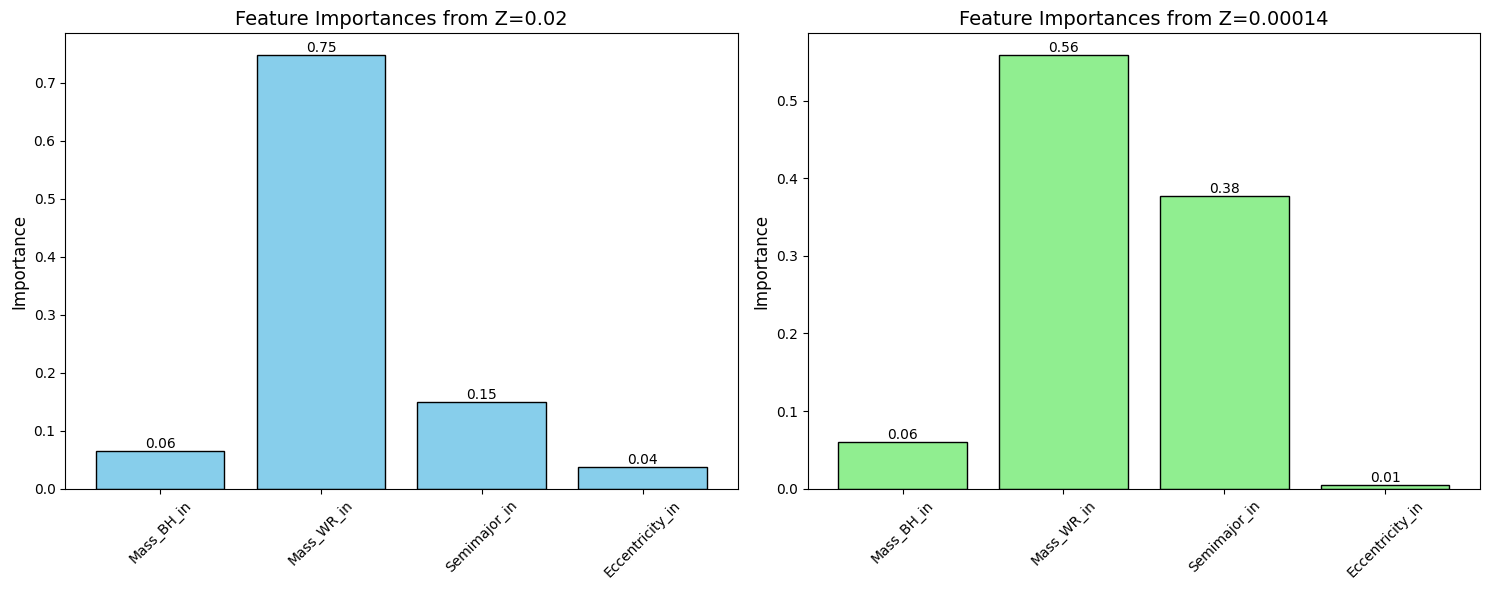

In [24]:
# Random Forest features importance 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))  

bars0 = axes[0].bar(features_in, best_RF0.feature_importances_, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Importance', fontsize=12)
axes[0].set_title('Feature Importances from Z=0.02', fontsize=14)
axes[0].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars0:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)


bars1 = axes[1].bar(features_in, best_RF1.feature_importances_, color='lightgreen', edgecolor='black')
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].set_title('Feature Importances from Z=0.00014', fontsize=14)
axes[1].tick_params(axis='x', labelsize=10, rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  
plt.show()

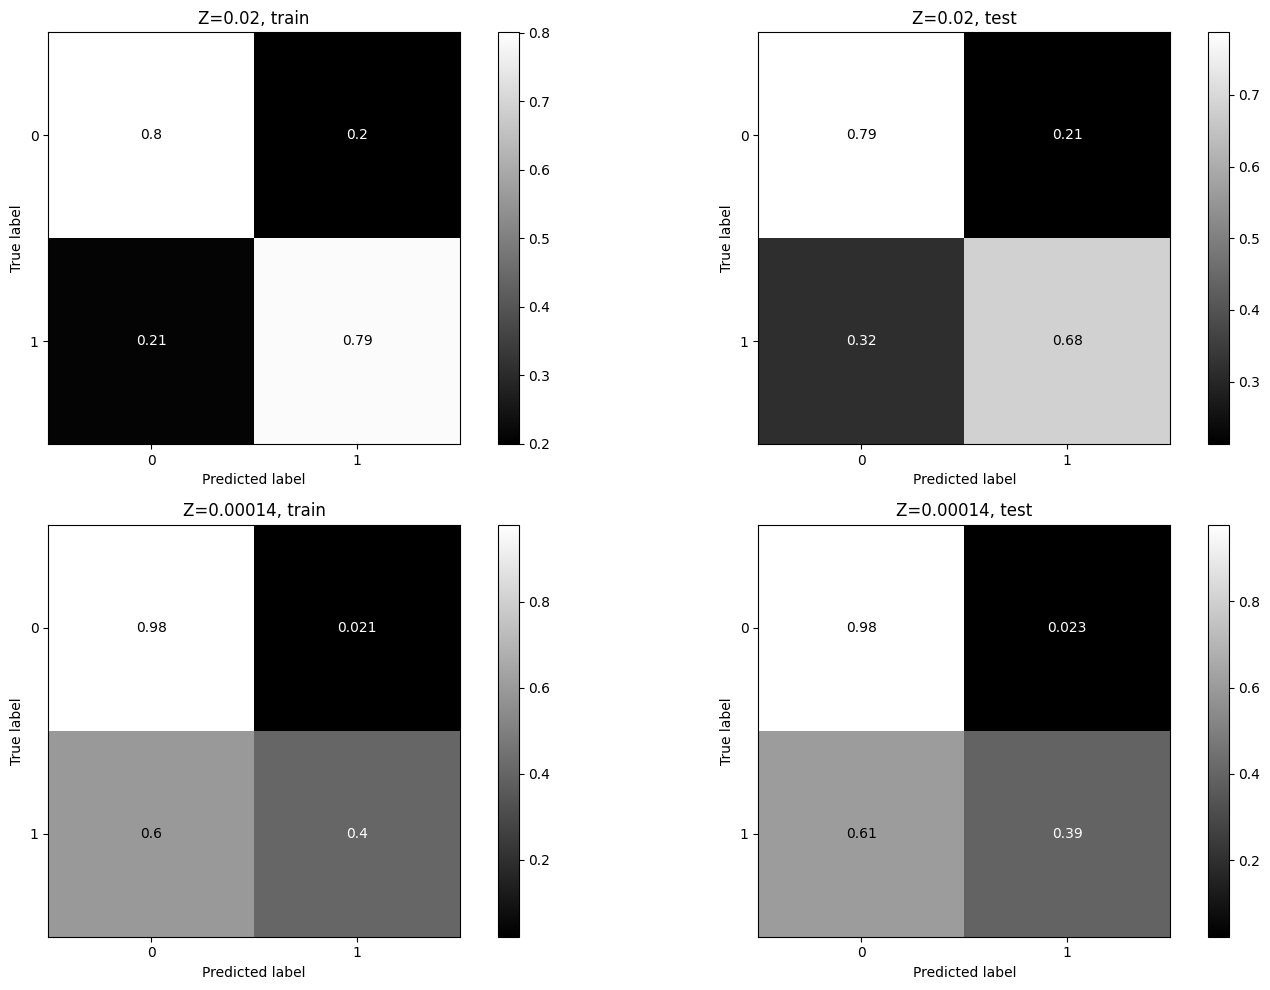

In [27]:
# confusion matrices

cm_0_train=confusion_matrix(y0_train,pred0_train,normalize='true')
cm_0_test=confusion_matrix(y0_test,pred0_test,normalize='true')
cm_1_train=confusion_matrix(y1_train,best_RF1.predict(x1_train),normalize='true')
cm_1_test=confusion_matrix(y1_test,best_RF1.predict(x1_test),normalize='true')

fig,ax=plt.subplots(2,2,figsize=(15,10))
ConfusionMatrixDisplay(cm_0_train).plot(ax=ax[0, 0], cmap='grey')
ConfusionMatrixDisplay(cm_0_test).plot(ax=ax[0, 1], cmap='grey')
ConfusionMatrixDisplay(cm_1_train).plot(ax=ax[1, 0], cmap='grey')
ConfusionMatrixDisplay(cm_1_test).plot(ax=ax[1, 1], cmap='grey')
ax[0, 0].set_title('Z=0.02, train')
ax[0, 1].set_title('Z=0.02, test')
ax[1, 0].set_title('Z=0.00014, train')
ax[1, 1].set_title('Z=0.00014, test')

plt.tight_layout()
plt.show()